In [1]:
import sys

MAIN_DICT = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability"
sys.path.append(MAIN_DICT)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import TemporalFusionTransformerEstimator
from sklearn.metrics import mean_squared_error

In [3]:
from utils.dataset import SlowEarthquakeDataset
from utils.nn_io import save_model

In [4]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [5]:
EXPERIMENT = "p4581"
TS_COLUMN = "det_shear_stress"

dataset = SlowEarthquakeDataset([EXPERIMENT])
ds_exp = dataset[EXPERIMENT]
X, Y, t = ds_exp["X"], ds_exp["Y"], ds_exp["t"]

ts_data = pd.DataFrame(
    np.hstack((X, Y, t.reshape(-1, 1))),
    columns=[ds_exp["hdrs"]["X"], *ds_exp["hdrs"]["Y"], ds_exp["hdrs"]["t"]],
)

ts_data = ts_data.dropna(axis=1)
ts_data.head()

,det_shear_stress,obs_shear_stress,obs_normal_stress,time
0,0.002811,1.29911,2.99288,0.000
1,0.002731,1.29903,2.99008,0.001
2,0.002231,1.29853,2.98854,0.002
3,0.002411,1.29871,2.98849,0.003
4,0.002241,1.29854,2.99069,0.004


In [6]:
ts_data = ts_data.rolling(window=int(1e2), step=int(1e2)).mean().dropna()
ts_data = ts_data.reset_index(drop=True)
ts_data = ts_data.dropna()
ts_data.head()

,det_shear_stress,obs_shear_stress,obs_normal_stress,time
0,0.003316,1.299621,2.989553,0.050500
1,0.005091,1.301409,2.989707,0.150501
2,0.006774,1.303105,2.989653,0.250501
3,0.008249,1.304593,2.989767,0.350502
4,0.009786,1.306144,2.989687,0.450502


In [7]:
# AIRLINES_CSV_URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
# TS_COLUMN = "Passengers"

# ts_data = pd.read_csv(AIRLINES_CSV_URL, index_col=0, parse_dates=True)
# ts_data.head()

In [8]:
dummy_idx = pd.date_range("2024-01-01", periods=len(ts_data), freq="M")
ts_data = ts_data.set_index(dummy_idx)

In [9]:
train_size = int(len(ts_data) * 0.8)
test_size = len(ts_data) - train_size

dataset = PandasDataset(ts_data, target=TS_COLUMN)

forecast = 1
windows = int(test_size / forecast)

training_data, test_gen = split(dataset, offset=-test_size)
test_data = test_gen.generate_instances(
    prediction_length=forecast, windows=windows
)

In [10]:
model = TemporalFusionTransformerEstimator(
    prediction_length=forecast,
    freq="M",
    context_length=50,
    trainer_kwargs={"max_epochs": 25, "devices": 1},
).train(training_data)

/home/users/p341cam/miniconda3/envs/venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/users/p341cam/miniconda3/envs/venv/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/users/p341cam/miniconda3/envs/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/gener

Training: |                                 | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 0.36573 (best 0.36573), saving model to '/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/notebooks/lightning_logs/version_18/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 0.14462 (best 0.14462), saving model to '/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/notebooks/lightning_logs/version_18/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 0.09758 (best 0.09758), saving model to '/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/notebooks/lightning_logs/version_18/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 0.08146 (best 0.08146), saving model to '/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/notebooks/lightning_logs/version_18/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' rea

In [11]:
from sklearn.metrics import r2_score

fcast = list(model.predict(test_data.input))
test_outputs = np.array([x["0.5"] for x in fcast]).reshape(-1)
test_iqr = np.array([0.5 * (x["0.9"] - x["0.1"]) for x in fcast]).reshape(-1)
test_rmse = np.sqrt(
    mean_squared_error(
        test_outputs, ts_data.iloc[train_size:][TS_COLUMN].values
    )
)

test_r2 = r2_score(test_outputs, ts_data.iloc[train_size:][TS_COLUMN].values)
print(f"Test RMSE: {test_rmse:.4f}, Test R^2: {test_r2:.4f}")

Test RMSE: 0.0247, Test R^2: 0.8723


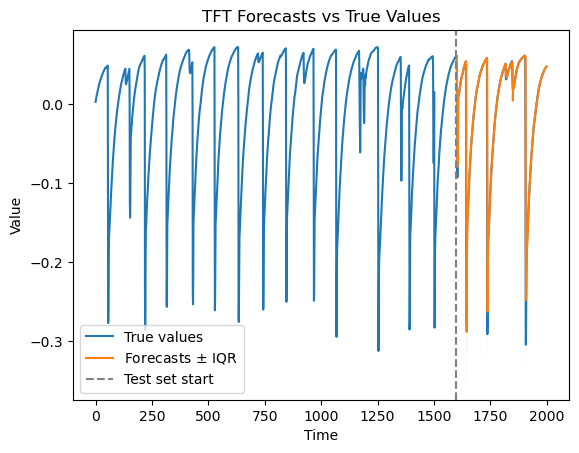

In [12]:
train_outputs = np.array([[np.nan] for x in range(train_size)]).reshape(-1)
train_iqr = np.array([[np.nan] for x in range(train_size)]).reshape(-1)

all_outputs = np.concatenate((train_outputs, test_outputs))
all_iqr = np.concatenate((train_iqr, test_iqr))

test_start_index = len(ts_data) - test_size

plt.plot(ts_data[TS_COLUMN].values, label="True values")
plt.plot(
    range(0, len(all_outputs)),
    all_outputs,
    label=r"Forecasts $\pm$ IQR",
)
plt.fill_between(
    range(0, len(all_outputs)),
    all_outputs - all_iqr,
    all_outputs + all_iqr,
    alpha=0.3,
    facecolor="#FF9848",
)

plt.axvline(
    x=test_start_index, color="gray", linestyle="--", label="Test set start"
)
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("TFT Forecasts vs True Values")
plt.show()

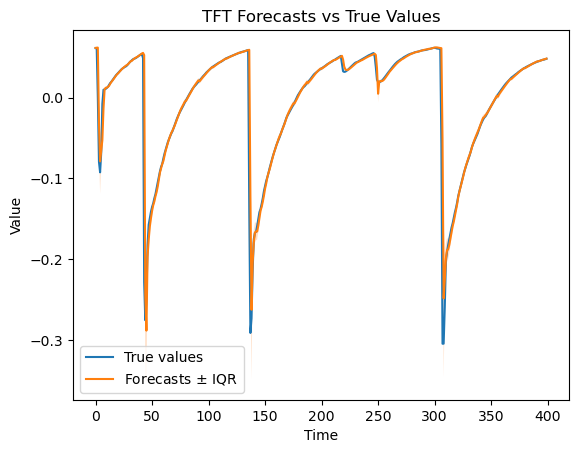

In [13]:
plt.plot(ts_data[TS_COLUMN].values[train_size:], label="True values")
plt.plot(
    range(test_size),
    test_outputs,
    label=r"Forecasts $\pm$ IQR",
)

plt.fill_between(
    range(0, test_size),
    test_outputs - test_iqr,
    test_outputs + test_iqr,
    alpha=0.3,
    facecolor="#FF9848",
)

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("TFT Forecasts vs True Values")
plt.show()

In [14]:
save_model(
    model,
    ts_data[TS_COLUMN].values,
    pred=all_outputs,
    pred_index=range(0, len(all_outputs)),
    gluon_ts=True,
)

model and data saved to /gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/results/p341cam_2024-01-27T15:43:26_gluonts
